## Solving Banana Collector Environment with Deep Q-Network using Prioritized Experience Replay, Fixed Q-Targets and Double DQN

Imports

In [1]:
import random
from collections import namedtuple, deque, OrderedDict
import heapq
import itertools
import math

from unityagents import UnityEnvironment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Setting global variables, device and random seed.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

seed = 5
random.seed(seed)
torch.manual_seed(seed)
print('Seed:', seed)

Device: cuda:0
Seed: 5


Setting up the environment

In [3]:
env = UnityEnvironment(file_name='Banana_Linux/Banana.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print('Brain name:', brain_name)

env_info = env.reset(train_mode=True)[brain_name]
print('Number of agents:', len(env_info.agents))

action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

state = env_info.vector_observations[0]
print('State example:', state)

state_size = len(state)
print('State size:', state_size)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Brain name: BananaBrain
Number of agents: 1
Number of actions: 4
State example: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
State size: 37


## Prioritized Experience Replay

Generation of segments for importance sampling based on ranking, higher `priority_exp` skews segments more.

In [4]:
def compute_priority_segments(num_segments, priority_exp):
    return [(i / num_segments) ** (priority_exp + 1) for i in range(num_segments + 1)]
 
def demo_compute_priority_segments():
    priority_exps = [0, 0.25, 0.5, 0.75, 1]
    segments = {e: compute_priority_segments(5, e) for e in priority_exps}
    
    df = pd.DataFrame(segments)
    df.columns.name = 'priority exponent'
    df.index.name = 'segment boundaries'
    pd.set_option('precision', 3)
    display(df)
        
demo_compute_priority_segments()

priority exponent,0.0,0.25,0.5,0.75,1.0
segment boundaries,,,,,
0,0.0,0.000,0.000,0.000,0.00
1,0.2,0.134,0.089,0.060,0.04
2,0.4,0.318,0.253,0.201,0.16
3,0.6,0.528,0.465,0.409,0.36
4,0.8,0.757,0.716,0.677,0.64
5,1.0,1.000,1.000,1.000,1.00


Computes importance sampling probabilities. Higher ranked items have higher sampling probability. Probabilities of all ranks should sum up to 1.

In [5]:
def compute_rank_probs(ranks, memory_size, priority_exp):
    return (1 - priority_exp) / ranks**priority_exp / (memory_size**(1 - priority_exp) - 1)

def demo_compute_rank_probs():
    ranks = np.array([1, 20, 40, 60, 80, 100])
    priority_exps = [0, 0.25, 0.5, 0.75, 0.99]
    rank_probs = {e: compute_rank_probs(ranks, 100, e) for e in priority_exps}
    
    df = pd.DataFrame(rank_probs, index=ranks)
    df.columns.name = 'priority exponent'
    df.index.name = 'rank'
    pd.set_option('precision', 3)
    display(df)

demo_compute_rank_probs()

priority exponent,0.0,0.25,0.5,0.75,0.99
rank,,,,,
1,0.01,0.024,0.056,0.116,0.212
20,0.01,0.012,0.012,0.012,0.011
40,0.01,0.010,0.009,0.007,0.006
60,0.01,0.009,0.007,0.005,0.004
80,0.01,0.008,0.006,0.004,0.003
100,0.01,0.008,0.006,0.004,0.002


Compute parameter update weights based on importance sampling probabilities. Higher probability should be assigned lower weight to avoid skewed distribution learned by the qnet.

In [6]:
def compute_sample_weights(sample_probs, memory_size, priority_exp, sample_exp):
    min_sample_prob = compute_rank_probs(memory_size, memory_size, priority_exp)
    max_sample_weight = (memory_size * min_sample_prob)**(-sample_exp)
    sample_weights = (memory_size * sample_probs)**(-sample_exp) / max_sample_weight
    return sample_weights
    
def demo_compute_sample_weights():
    memory_size = 100
    priority_exp = 0.5
    ranks = np.array([1, 20, 40, 60, 80, 100])
    sample_exps = [0, 0.25, 0.5, 0.75, 1]
    sample_probs = compute_rank_probs(ranks, memory_size, priority_exp)
    sample_weights = {e: compute_sample_weights(sample_probs, memory_size, priority_exp, e) for e in sample_exps}

    df = pd.DataFrame(sample_weights, index=ranks)
    df.index.name = 'rank'
    df.columns.name = 'sample exponent'
    pd.set_option('precision', 3)
    display(df)

demo_compute_sample_weights()

sample exponent,0.0,0.25,0.5,0.75,1.0
rank,,,,,
1,1.0,0.562,0.316,0.178,0.100
20,1.0,0.818,0.669,0.547,0.447
40,1.0,0.892,0.795,0.709,0.632
60,1.0,0.938,0.880,0.826,0.775
80,1.0,0.972,0.946,0.920,0.894
100,1.0,1.000,1.000,1.000,1.000


Implementation of priority replay memory, which uses binary heap to keep experiences in approximately sorted order by TD-error. Importance sampling is implemented using unevenly sized segments, i.e. segment size decreases from top to bottom of the heap. Number of segments is equal to the batch size. One experience is sampled per segment.

In [7]:
class PriorityReplayMemory:
    def __init__(self, 
                 memory_size, # (int) max size of memory
                 batch_size, # (int) number of items to sample in one batch
                 priority_exp, # (float) priority exponent controls the uniformness of sampling
                 sort_freq # (int) number of items added before the heap is resorted
                ):
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.priority_exp = priority_exp
        self.sort_freq = sort_freq

        self.heap = []  # min-heap to store experiences
        self.step = 0

        self.segments = compute_priority_segments(batch_size, priority_exp)
        self.counter = itertools.count()

    def add(self, experience, error=None):
        if error is None:  # new expereinces get maximal priority
            if len(self.heap) > 0:
                priority = self.heap[0][0]
            else:
                priority = -10  # some default value
        else:
            priority = -error  # min heap stores min priority first

        count = next(self.counter)
        heapq.heappush(self.heap, (priority, count, experience))

        # Remove last experience
        if len(self.heap) > self.memory_size:
            self.heap.pop()

        # Resort the heap every sort_freq times: O(n*log(n))
        self.step = (self.step + 1) % self.sort_freq

        if self.step == 0:
            self.heap.sort(key=lambda x: x[0])

    def sample(self, sample_exp):
        size = len(self.heap)

        # Scale segements to the number of experiences
        segments = [(math.ceil(start * (size - 1)), math.floor(end * (size - 1)))
                    for start, end in zip(self.segments[:-1], self.segments[1:])]

        # Check if the first (smallest) segment contains more than one experience
        if segments[0][0] < segments[0][1]:
            indexes = [random.randint(start, end) for start, end in segments]
        else:  # Ignore segments, do uniform sampling
            indexes = random.sample(range(size), self.batch_size)

        # Select experiences
        experiences = [self.heap[i][2] for i in indexes]

        # Compute importance-sampling weights
        ranks = np.array(indexes) + 1
        probs = compute_rank_probs(ranks, self.memory_size, self.priority_exp)
        weights = compute_sample_weights(probs, self.memory_size, self.priority_exp, sample_exp)

        # Remove sampled experiences
        for index in sorted(indexes, reverse=True):
            del self.heap[index]

        return experiences, weights

    def __len__(self):
        return len(self.heap)


def demo_priority_replay_memory():
    memory = PriorityReplayMemory(memory_size=100, batch_size=10, priority_exp=0.5, sort_freq=10)

    for i in range(1000):
        memory.add(i, i)

    exps, probs = memory.sample(0.5)
    df = pd.DataFrame({'error': exps, 'weight': probs})
    pd.set_option('precision', 3)
    return df


demo_priority_replay_memory()

,error,weight
0,997,0.416
1,988,0.514
2,978,0.562
3,908,0.707
4,866,0.740
5,696,0.828
6,686,0.832
7,39,0.884
8,27,0.924
9,9,0.977


## Q-network

Q-network with parameterized number of hidden layers.

In [8]:
def make_qnet(state_size, action_size, hidden_sizes):
    layers = OrderedDict()
    prev_size = state_size

    for i, size in enumerate(hidden_sizes):
        layers['fc{}'.format(i)] = nn.Linear(prev_size, size)
        layers['bc{}'.format(i)] = nn.BatchNorm1d(size)
        layers['relu{}'.format(i)] = nn.ReLU()
        prev_size = size
    
    layers['fc{}'.format(len(hidden_sizes))] = nn.Linear(prev_size, action_size)
    return nn.Sequential(layers)
    
make_qnet(state_size, action_size, [64, 64])

Sequential(
  (fc0): Linear(in_features=37, out_features=64, bias=True)
  (bc0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU()
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (bc1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

## DQN Agent

DQN agent that implements prioritized experience replay, fixed Q-targets and Double DQN enhancements.

In [9]:
Experience = namedtuple('Experience', 'state action reward next_state done')

def get_fields_from_experiences(experiences):
    states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)
    return states, actions, rewards, next_states, dones

class PriorityDoubleDQNAgent:
    def __init__(self,
                 state_size, # (int)
                 action_size, # (int)
                 replay_memory_size, # (int) max size of memory
                 replay_batch_size, # (int) number of items to sample in one batch
                 replay_priority_exp, # (float) priority exponent controls the uniformness of sampling
                 replay_sort_freq, # (int) number of items added before the heap is resorted
                 replay_start, # (int) number of experiences to collect before learning starts
                 qnet_hidden_sizes, # (list[int]) sizes of hidden layers in Q-networks
                 learn_freq, # (int) steps between learning
                 learn_rate, # (float) how much to learn in each parameter update of online Q-network
                 discount_factor, # (float) discounts the reward from consequent states
                 target_update_freq, # (int) number of parameter updates before updated the target Q-network
                 soft_update_factor # (float) how much to update the target from online Q-network
                ):
        self.action_size = action_size
        self.replay_start = replay_start
        self.learn_freq = learn_freq
        self.discount_factor = discount_factor
        self.target_update_freq = target_update_freq
        self.soft_update_factor = soft_update_factor
        
        self.replay_memory = PriorityReplayMemory(
            replay_memory_size, 
            replay_batch_size, 
            replay_priority_exp, 
            replay_sort_freq
        )
        
        self.online_qnet = make_qnet(state_size, action_size, qnet_hidden_sizes).to(device)
        self.target_qnet = make_qnet(state_size, action_size, qnet_hidden_sizes).to(device)
        self.optimizer = optim.Adam(self.online_qnet.parameters(), lr=learn_rate)

        self.learn_step = 0
        self.target_update_step = 0

    def perceive(self, state, action, reward, next_state, done, sample_exp):
        experience = Experience(state, action, reward, next_state, done)
        self.replay_memory.add(experience)

        self.learn_step = (self.learn_step + 1) % self.learn_freq

        if self.learn_step == 0 and len(self.replay_memory) >= self.replay_start:
            self.learn(sample_exp)

    def act(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.online_qnet.eval()

        with torch.no_grad():
            action_values = self.online_qnet(state)

        self.online_qnet.train()

        # Epsilon-greedy action selection
        if random.random() > epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, sample_exp):
        experiences, sample_weights = self.replay_memory.sample(sample_exp)
        states, actions, rewards, next_states, dones = get_fields_from_experiences(experiences)

        # Get actions for next states from online Q-network (Double DQN)
        expected_next_actions = self.online_qnet(next_states).detach().max(1)[1].unsqueeze(1)
        # Get Q values for next actions from target Q-network
        Q_next_targets = self.target_qnet(next_states).detach().gather(1, expected_next_actions)
        # Compute Q targets for current states
        Q_targets = rewards + self.discount_factor * Q_next_targets * (1 - dones)
        # Get expected Q values from online model
        Q_expected = self.online_qnet(states).gather(1, actions)
        # Compute TD errors
        td_errors = Q_targets - Q_expected

        # Use absolute td_error as priorities
        priorities = td_errors.detach().cpu().abs().squeeze().numpy()
        
        # Readd sampled experiences with new priorities
        for experience, priority in zip(experiences, priorities):
            self.replay_memory.add(experience, priority)

        # Compute loss with importance-sampling weights
        sample_weights = torch.from_numpy(sample_weights).float().unsqueeze(1).to(device)
        loss = (sample_weights * td_errors ** 2).mean()

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update of the target model every target_update_freq times
        self.target_update_step = (self.target_update_step + 1) % self.target_update_freq

        if self.target_update_step == 0:
            for target_param, online_param in zip(self.target_qnet.parameters(), self.online_qnet.parameters()):
                target_param.data.copy_(
                    self.soft_update_factor * online_param.data + (1.0 - self.soft_update_factor) * target_param.data)

Episode 100	Average Score: 0.42
Episode 200	Average Score: 3.75
Episode 300	Average Score: 7.52
Episode 400	Average Score: 11.15
Episode 500	Average Score: 12.65
Episode 516	Average Score: 13.01
Environment solved in 416 episodes!	Average Score: 13.01


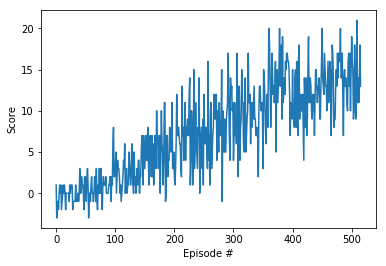

In [10]:
def train(
    agent,
    max_episodes, # (int) maximum number of training episodes
    max_steps, # (int) maximum number of steps per episode
    goal_score, # (int) average score to achive over 100 episodes 
    epsilon_start, # (float) start value of epsilon, for epsilon-greedy action selection
    epsilon_end, # (float) minimum value of epsilon
    epsilon_decay, # (float) multiplicative factor (per episode) for decreasing epsilon
    sample_exp_start, # (float) start value fo importance-sampling exponent
    sample_exp_end,  # (float) end value fo importance-sampling exponent
    model_path # (str) file path to save the Q-network parameters
):
    scores = [] # list containing scores from each episode
    scores_window = deque(maxlen=100) # last 100 scores
    epsilon = epsilon_start # initialize epsilon
    
    sample_exp = sample_exp_start
    sample_exp_step = (sample_exp_end - sample_exp_start) / max_episodes
    
    for episode in range(1, max_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] # get the current state
        score = 0 # initialize the score
        
        for step in range(max_steps):
            action = agent.act(state, epsilon)
            
            env_info = env.step(action)[brain_name] # send the action to the environment
            next_state = env_info.vector_observations[0] # get the next state
            reward = env_info.rewards[0] # get the reward
            done = env_info.local_done[0] # see if episode has finished
                
            agent.perceive(state, action, reward, next_state, done, sample_exp)
            
            state = next_state
            score += reward
            
            if done:
                break
        
        scores_window.append(score) # save most recent score
        scores.append(score) # save most recent score
        epsilon = max(epsilon_end, epsilon_decay * epsilon) # decrease epsilon
        sample_exp += sample_exp_step # increase important-sampling exponent
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)), end="")
        
        if episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        
        if np.mean(scores_window) >= goal_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, np.mean(scores_window)))
            torch.save(agent.online_qnet.state_dict(), model_path)
            break
    
    return scores

def plot_scores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

agent = PriorityDoubleDQNAgent(
    state_size=state_size, 
    action_size=action_size,
    replay_memory_size=int(1e5),
    replay_batch_size=32,
    replay_priority_exp=0.5,
    replay_sort_freq=int(1e3),
    replay_start=500,
    qnet_hidden_sizes=[64, 64],
    learn_freq=4,
    learn_rate=5e-4,
    discount_factor=0.99,
    target_update_freq=1,
    soft_update_factor=1e-3
)

scores = train(
    agent=agent,  
    max_episodes=1000, 
    max_steps=1000, 
    goal_score=13, 
    epsilon_start=1.0, 
    epsilon_end=0.01,
    epsilon_decay=0.995,
    sample_exp_start=0,
    sample_exp_end=0.5,
    model_path='models/dqn.pth'
)

plot_scores(scores)

See the agent in action

In [11]:
def test(agent, epsilon=0.01):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0] # get the current state
    score = 0 # initialize the score

    while True:
        action = agent.act(state, epsilon) # select an action
        env_info = env.step(action)[brain_name] # send the action to the environment
        next_state = env_info.vector_observations[0] # get the next state
        reward = env_info.rewards[0] # get the reward
        done = env_info.local_done[0] # see if episode has finished
        score += reward # update the score
        state = next_state # roll over the state to next time step
        
        if done: # exit loop if episode finished
            break
    
    print("Score: {}".format(score))
    
test(agent)

Score: 14.0


In [ ]:
env.close()